In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
# import tensorflow_recommenders as tfrs
# import tensorflow_datasets as tfds

In [ ]:
!pip install tensorflowjs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
product_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/product.csv", usecols=range(10))
customer_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/customer.csv")

In [ ]:
click_stream_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/click_stream_new.csv")
transaction_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/transaction_new.csv")


#EDA

#Creating user matrix for recommender system

##Joining clickstream with transaction

###Taking important event for the interaction score calculation

In [ ]:
click_stream_filtered = click_stream_df[click_stream_df['event_name'].isin(['ITEM_DETAIL', 'ADD_TO_CART','BOOKING'])]
clickstream_with_customer = click_stream_filtered.merge(
    transaction_df[['session_id', 'customer_id']],
    on='session_id',
    how='inner'
)
set(clickstream_with_customer['event_name'])

{'ADD_TO_CART', 'BOOKING', 'ITEM_DETAIL'}

###Applying the weighted event for interaction score calculation

In [ ]:
event_weights = {'ADD_TO_CART': 3, 'ITEM_DETAIL': 2, 'BOOKING': 4}
clickstream_with_customer['interaction_score'] = clickstream_with_customer['event_name'].map(event_weights)

###Aggregating the data by the customer id and product id

In [ ]:
clickstream_aggregated = clickstream_with_customer.groupby(
    ['customer_id', 'product_id'], as_index=False
).agg({'interaction_score': 'sum'})

**Insights** : Customer who is successfully doing payment (booking event name) are has high interaction score, adding to cart also has high interaction score, but for item detail and click it has low interaction score

###Adding another table for interaction score calculation which is the quantity

In [ ]:
transaction_aggregated = transaction_df.groupby(
    ['customer_id', 'product_id'], as_index=False
).agg({'quantity': 'sum'})

In [ ]:
transaction_aggregated.rename(columns={'quantity': 'interaction_score'}, inplace=True)

In [ ]:
combined_interactions = pd.concat([transaction_aggregated, clickstream_aggregated], ignore_index=True)

In [ ]:
final_interactions = combined_interactions.groupby(
    ['customer_id', 'product_id'], as_index=False
).agg({'interaction_score': 'sum'})

###Normalize the interaction score

In [ ]:
scaler = MinMaxScaler()
final_interactions['interaction_score'] = scaler.fit_transform(final_interactions[['interaction_score']])

In [ ]:
train_data, test_data = train_test_split(final_interactions, test_size=0.2, random_state=42)

In [ ]:
num_customers = final_interactions['customer_id'].nunique()
num_products = final_interactions['product_id'].nunique()
embedding_dim = 32
customer_id_mapping = {id: index for index, id in enumerate(final_interactions['customer_id'].unique())}
product_id_mapping = {id: index for index, id in enumerate(final_interactions['product_id'].unique())}

In [ ]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        # Check if validation loss is below the threshold
        val_loss = logs.get('val_loss')
        if val_loss and val_loss <= self.threshold:
            print(f"\nStopping training as validation loss has reached {val_loss:.5f}, below the threshold {self.threshold}.")
            self.model.stop_training = True

# Define the callback with the desired threshold
threshold = 0.0055
early_stopping_callback = CustomEarlyStopping(threshold=threshold)

In [ ]:
class CollaborativeFilteringModel(tf.keras.Model):
    def __init__(self, num_customers, num_products, embedding_dim):
        super().__init__()
        self.customer_embedding = tf.keras.layers.Embedding(num_customers, embedding_dim)
        self.product_embedding = tf.keras.layers.Embedding(num_products, embedding_dim)
        self.dot_product = tf.keras.layers.Dot(axes=1)

    def call(self, inputs):
        customer_vec = self.customer_embedding(inputs[0])
        product_vec = self.product_embedding(inputs[1])
        return self.dot_product([customer_vec, product_vec])

model = CollaborativeFilteringModel(num_customers, num_products, embedding_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mean_squared_error')

# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    (train_data['customer_id'].map(customer_id_mapping).values, train_data['product_id'].map(product_id_mapping).values),
    train_data['interaction_score'].values
)).batch(256).shuffle(10000).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    (test_data['customer_id'].map(customer_id_mapping).values, test_data['product_id'].map(product_id_mapping).values),
    test_data['interaction_score'].values
)).batch(256).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[early_stopping_callback])

Epoch 1/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 176s 29ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 2/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 199s 29ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 3/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 199s 28ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 4/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 208s 29ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 5/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 200s 29ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 6/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 197s 28ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 7/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 202s 28ms/step - loss: 0.0045 - val_loss: 0.0060
Epoch 8/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 187s 31ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 9/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 192s 29ms/step - loss: 0.0033 - val_loss: 0.0056
Epoch 10/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0028
Stopping training as validation loss has reached 0.00548, below the threshold 0.0055.
5905/5905 ━━━━

###Generate the recommendation

In [ ]:
def recommend_for_customer(customer_id, num_recommendations=10):
    all_product_ids = np.arange(num_products)

    customer_ids = np.full_like(all_product_ids, customer_id)

    product_ids = all_product_ids
    predictions = model.predict([customer_ids, product_ids])

    top_indices = np.argsort(predictions.flatten())[::-1]

    top_product_ids = product_ids[top_indices][:num_recommendations]


    return top_product_ids

recommended_products = recommend_for_customer(3, num_recommendations=10)
print("Top 10 recommended products for customer 3:", recommended_products)


1389/1389 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
[3 3 3 ... 3 3 3]
Top 10 recommended products for customer 3: [ 7676 13068 42888 34293 29631 34075 20757 33377 13297 28064]


###Saving the model in tfjs

In [ ]:
import tensorflowjs as tfjs

saved_model_path = "/content/drive/MyDrive/Colab Notebooks/models/collaborative_filtering_model.keras" # Added .keras extension
model.save(saved_model_path)

tfjs_target_dir = "/content/drive/MyDrive/Colab Notebooks/models/tfjs_collaborative_filtering_model"
tfjs.converters.save_keras_model(model, tfjs_target_dir)

print(f"Model saved for TensorFlow.js at: {tfjs_target_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
Model saved for TensorFlow.js at: /content/drive/MyDrive/Colab Notebooks/models/tfjs_collaborative_filtering_model


###Analyzing the loss for validation and train test

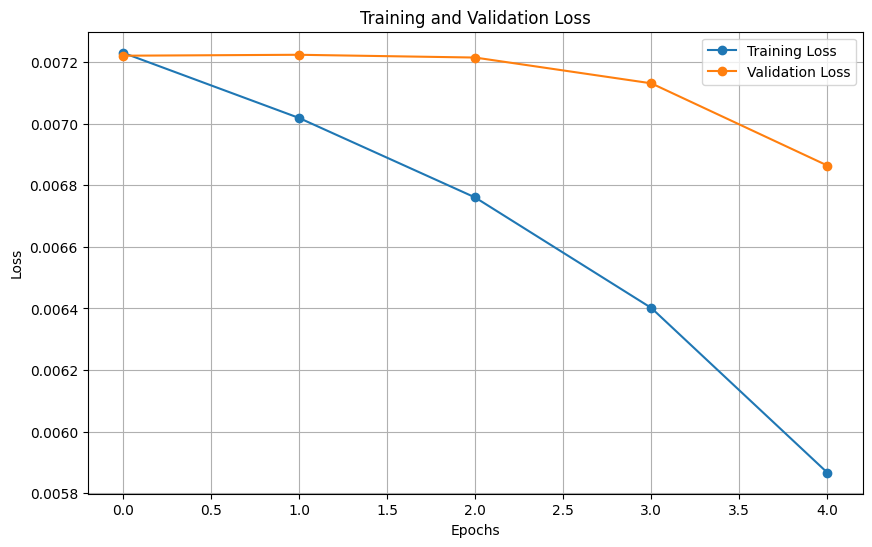

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'][:5], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'][:5], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
history.history

{'loss': [0.007229878567159176,
  0.007018148899078369,
  0.006760060787200928,
  0.006401566322892904,
  0.005866761785000563,
  0.005153872538357973,
  0.004411728587001562,
  0.003766868729144335,
  0.0032326113432645798,
  0.002782464027404785],
 'val_loss': [0.0072201918810606,
  0.007223209366202354,
  0.007214212324470282,
  0.007130580022931099,
  0.006863611284643412,
  0.006432713475078344,
  0.006017055828124285,
  0.005725420545786619,
  0.005556683521717787,
  0.005477130878716707]}

In [ ]:
model.evaluate(test_dataset)

1477/1477 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0056


0.005477130878716707

###Using Neural Network Collaborative Filterinng

In [ ]:
class NeuralCollaborativeFilteringModel(tf.keras.Model):
    def __init__(self, num_customers, num_products, embedding_dim):
        super().__init__()
        self.customer_embedding = tf.keras.layers.Embedding(num_customers, embedding_dim)
        self.product_embedding = tf.keras.layers.Embedding(num_products, embedding_dim)
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs):
        customer_vec = self.customer_embedding(inputs[0])
        product_vec = self.product_embedding(inputs[1])
        x = tf.concat([customer_vec, product_vec], axis=-1)
        return self.dense(x)
model2 = NeuralCollaborativeFilteringModel(num_customers, num_products, embedding_dim)
model2.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mean_squared_error')

# Prepare datasets
train_dataset2 = tf.data.Dataset.from_tensor_slices((
    (train_data['customer_id'].map(customer_id_mapping).values, train_data['product_id'].map(product_id_mapping).values),
    train_data['interaction_score'].values
)).batch(256).shuffle(10000).prefetch(tf.data.AUTOTUNE)

test_dataset2 = tf.data.Dataset.from_tensor_slices((
    (test_data['customer_id'].map(customer_id_mapping).values, test_data['product_id'].map(product_id_mapping).values),
    test_data['interaction_score'].values
)).batch(256).prefetch(tf.data.AUTOTUNE)


early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)
# Train the model
history2 = model2.fit(train_dataset2, validation_data=test_dataset2, epochs=100, callbacks=[early_stopping])

Epoch 1/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 222s 36ms/step - loss: 0.0299 - val_loss: 0.0039
Epoch 2/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 239s 32ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 3/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 195s 31ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 4/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 5/100
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 187s 31ms/step - loss: 0.0033 - val_loss: 0.0039


In [ ]:
def recommend_for_customer2(customer_id, num_recommendations=10):
    all_product_ids = np.arange(num_products)

    customer_ids = np.full_like(all_product_ids, customer_id)

    product_ids = all_product_ids
    predictions = model2.predict([customer_ids, product_ids])

    top_indices = np.argsort(predictions.flatten())[::-1]

    top_product_ids = product_ids[top_indices][:num_recommendations]


    return top_product_ids

recommended_products = recommend_for_customer2(3, num_recommendations=10)
print("Top 10 recommended products for customer 3:", recommended_products)


1389/1389 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Top 10 recommended products for customer 3: [11827 31509 38460  4063 36868 39765 15318 39450 42087 14886]


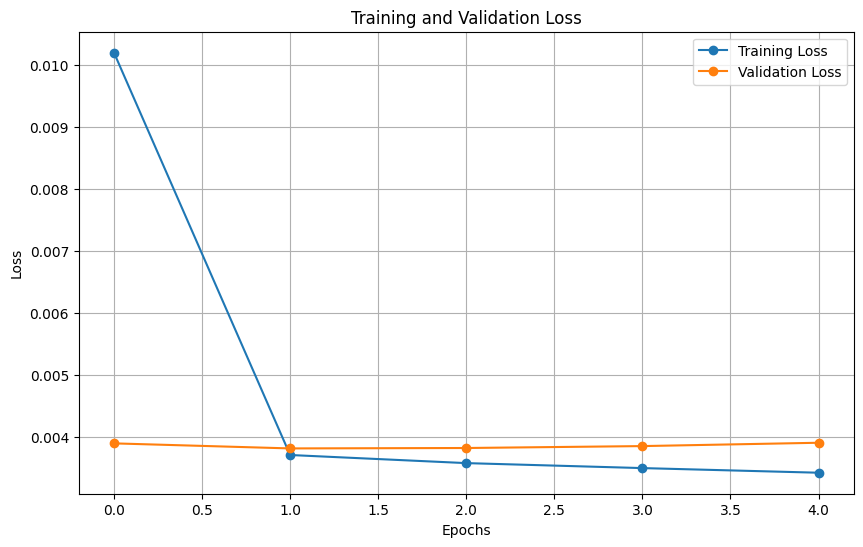

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss', marker='o')
plt.plot(history2.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

###Combining NLP with Colaborative filtering

In [ ]:
click_stream_df.columns

Index(['session_id', 'event_name', 'event_time', 'event_id', 'traffic_source',
       'product_id', 'quantity', 'item_price', 'payment_status',
       'search_keywords', 'promo_code', 'promo_amount'],
      dtype='object')

In [ ]:
product_df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

In [ ]:
!pip install tensorflow_text tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.3 MB/s eta 0:00:00


In [ ]:
event_weights2 = {
    "SEARCH": 1,
    "ITEM_DETAIL": 2,
    "ADD_TO_CART": 3,
    "BOOKING": 4
}

click_stream_filtered2 = click_stream_df[click_stream_df['event_name'].isin(event_weights.keys())]

click_stream_filtered2['interaction_score'] = click_stream_filtered['event_name'].map(event_weights)

clickstream_with_customer2 = click_stream_filtered2.merge(
    transaction_df[['session_id', 'customer_id']],
    on='session_id',
    how='inner'
)

clickstream_aggregated2 = clickstream_with_customer2.groupby(
    ['customer_id', 'product_id'], as_index=False
).agg({'interaction_score': 'sum'})


In [ ]:
transaction_aggregated2 = transaction_df.groupby(
    ['customer_id', 'product_id'], as_index=False
).agg({'quantity': 'sum'})

transaction_aggregated2.rename(columns={'quantity': 'interaction_score'}, inplace=True)

combined_interactions2 = pd.concat([transaction_aggregated2, clickstream_aggregated2], ignore_index=True)

final_interactions2 = combined_interactions2.groupby(
    ['customer_id', 'product_id'], as_index=False
).agg({'interaction_score': 'sum'})

scaler = MinMaxScaler()
final_interactions2['interaction_score'] = scaler.fit_transform(final_interactions2[['interaction_score']])
